[*********************100%***********************]  1 of 1 completed


C:\Users\AKSHAT\AppData\Local\Temp/ipykernel_4104/3472918532.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['EMA_RVI'] = data['RVI'].ewm(span=13, adjust=False).mean()
C:\Users\AKSHAT\AppData\Local\Temp/ipykernel_4104/3472918532.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Crossover'] = np.where(data['RVI'] > data['EMA_RVI'], 1, -1)


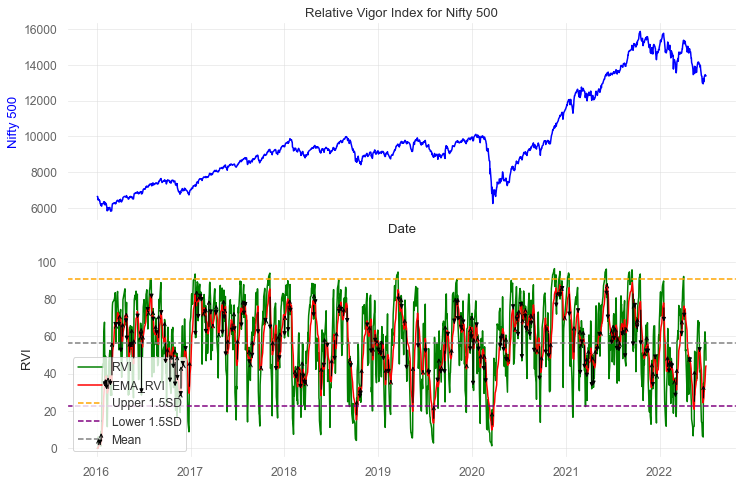

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2016-02-12   2016-02-12
End Period                 2022-07-01   2022-07-01
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       96.0%

Cumulative Return          129.23%      -100.0%
CAGR﹪                     9.38%        -94.82%

Sharpe                     0.84         0.53
Prob. Sharpe Ratio         97.85%       90.02%
Smart Sharpe               0.81         0.51
Sortino                    1.14         0.71
Smart Sortino              1.1          0.68
Sortino/√2                 0.81         0.5
Smart Sortino/√2           0.78         0.48
Omega                      1.13         1.13

Max Drawdown               -38.3%       -100.0%
Longest DD Days            495          1398
Volatility (ann.)          17.59%       422.2%
R^2                        0.85         0.85
Information Ratio          0.03         0.03
Calmar            

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2018-09-03,2020-03-27,2022-07-01,1398,-100.003173,-100.000074
2,2018-01-24,2018-03-23,2018-08-24,213,-67.629576,-63.713503
3,2017-09-20,2017-09-27,2017-10-12,23,-27.646407,-25.497729
4,2017-08-02,2017-08-11,2017-09-08,38,-21.202633,-17.626047
5,2017-11-28,2017-12-06,2017-12-15,18,-20.384490,-15.292675


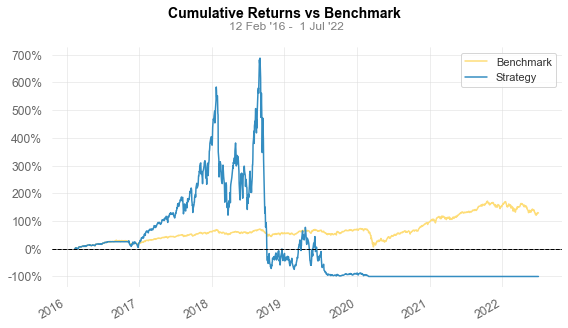

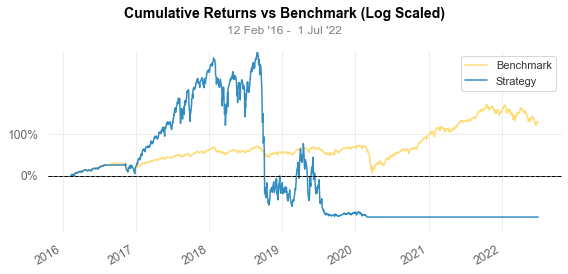

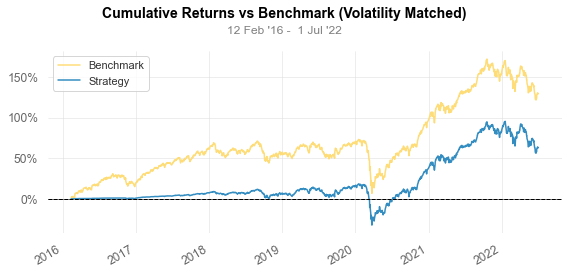

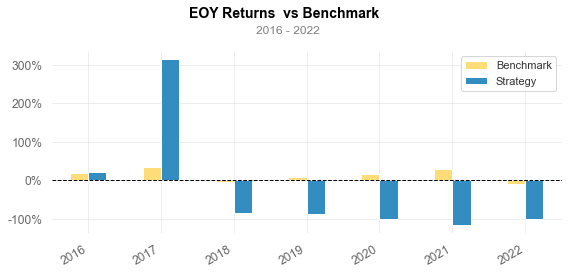

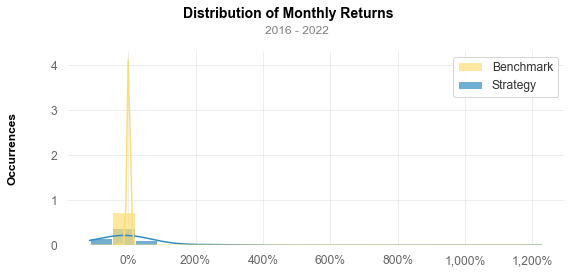

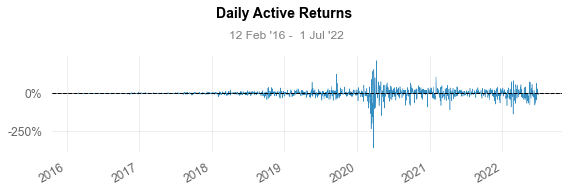

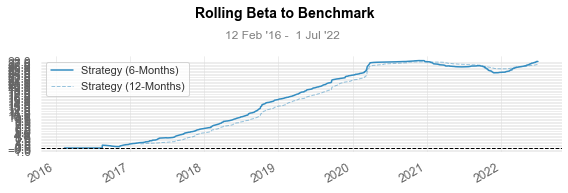

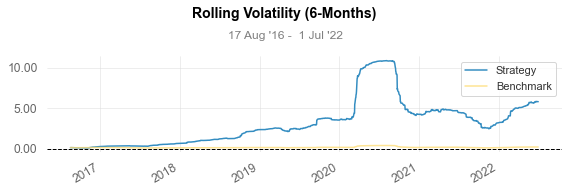

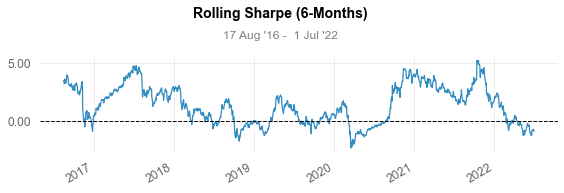

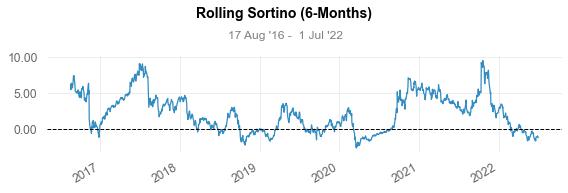

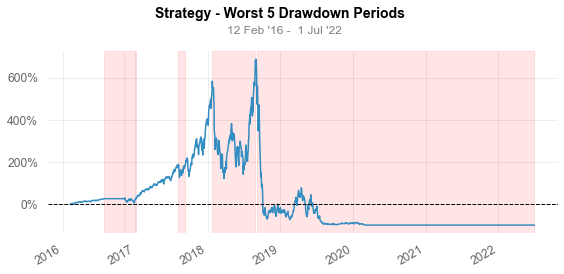

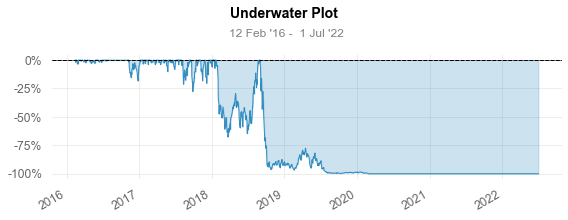

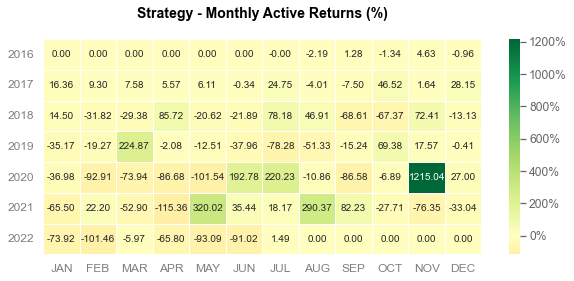

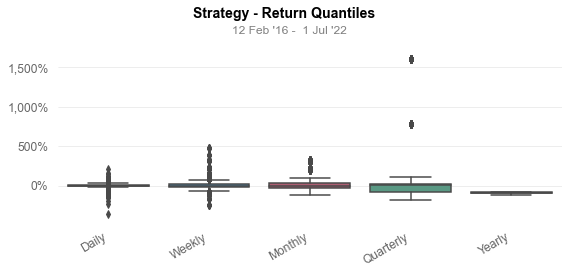

In [19]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
def calculate_rvi(symbol):
    # Fetch historical data from yfinance
    data = yf.download(symbol, start='2016-01-01', end='2022-07-04')

    # Calculate RVI
    data['HLC'] = (data['High'] + data['Low'] + data['Close']) / 3
    data['HLC_prev'] = data['HLC'].shift(1)
    data['CM'] = np.where(data['Close'] > data['Open'], data['Close'] - data['Open'], 0)
    data['VM'] = np.where(data['Close'] <= data['Open'], data['Close'] - data['Open'], 0)
    data['RVGI'] = data['HLC'] - data['HLC_prev']
    data['RVGI_up'] = np.where(data['RVGI'] > 0, data['RVGI'], 0)
    data['RVGI_down'] = np.where(data['RVGI'] < 0, abs(data['RVGI']), 0)
    data['RVGI_EMA_up'] = data['RVGI_up'].ewm(span=10, adjust=False).mean()
    data['RVGI_EMA_down'] = data['RVGI_down'].ewm(span=10, adjust=False).mean()
    data['RVI'] = (data['RVGI_EMA_up'] / (data['RVGI_EMA_up'] + data['RVGI_EMA_down'])) * 100

    # Remove NaN values
    data.dropna(inplace=True)

    return data[['Close', 'RVI']]

# Example usage for Nifty 500
nifty500 = '^CRSLDX'  # Symbol for Nifty 500 index
data = calculate_rvi(nifty500)

# Calculate 13-day EMA of RVI
data['EMA_RVI'] = data['RVI'].ewm(span=13, adjust=False).mean()

# Determine crossovers
data['Crossover'] = np.where(data['RVI'] > data['EMA_RVI'], 1, -1)

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot Nifty 500
ax1.plot(data.index, data['Close'], color='blue')
ax1.set_ylabel('Nifty 500', color='blue')

# Plot RVI and its 13-day EMA
ax2.plot(data.index, data['RVI'], color='green', label='RVI')
ax2.plot(data.index, data['EMA_RVI'], color='red', label='EMA_RVI')
ax2.set_ylabel('RVI')
ax2.grid(True)

# Mark crossovers with arrows
for i in range(1, len(data)):
    if data['Crossover'].iloc[i] != data['Crossover'].iloc[i - 1]:
        color = 'black' if data['Crossover'].iloc[i] > 0 else 'black'
        arrow_style = '->' if data['Crossover'].iloc[i] > 0 else '-|>'
        ax2.annotate('', xy=(data.index[i], data['RVI'].iloc[i]), xytext=(data.index[i], data['EMA_RVI'].iloc[i]),
                     arrowprops=dict(facecolor=color, edgecolor=color, arrowstyle=arrow_style), color=color,
                     fontsize=8, ha='center', va='center', xycoords='data', textcoords='data', zorder=10)
mean_rvi = data['RVI'].mean()
std_rvi = data['RVI'].std()

# Calculate upper and lower 2SD lines
upper_sd = mean_rvi + 1.5 * std_rvi
lower_sd = mean_rvi - 1.5 * std_rvi

# Plot upper and lower 2SD lines
ax2.axhline(upper_sd, linestyle='--', color='orange', label='Upper 1.5SD')
ax2.axhline(lower_sd, linestyle='--', color='purple', label='Lower 1.5SD')
ax2.axhline(mean_rvi, linestyle='--', color='gray', label='Mean')

ax1.set_title('Relative Vigor Index for Nifty 500')
ax1.set_xlabel('Date')

plt.legend()
plt.show()

def create_trading_strategy(data):
    # Calculate upper and lower 1.5 SD bands
    upper_sd = data['RVI'].mean() + 1.5 * data['RVI'].std()
    lower_sd = data['RVI'].mean() - 1.5 * data['RVI'].std()

    # Generate signals
    data['Signal'] = np.where((data['RVI'] > upper_sd) & (data['RVI'].shift(1) <= upper_sd), -1, 0)
    data['Signal'] = np.where((data['RVI'] < lower_sd) & (data['RVI'].shift(1) >= lower_sd), 1, data['Signal'])

    # Calculate positions
    data['Position'] = data['Signal'].cumsum()

    # Calculate strategy returns
    data['Strategy_Returns'] = data['Close'].pct_change() * data['Position'].shift(1)

    return data

# Backtest the strategy
data = create_trading_strategy(data.copy())

# Create a benchmark (buy and hold Nifty 500 on the first day)
benchmark = pd.DataFrame(index=data.index)
benchmark['Close'] = data['Close']
benchmark['Position'] = 1  # Buy and hold

# Calculate benchmark returns
benchmark['Benchmark_Returns'] = benchmark['Close'].pct_change() * benchmark['Position']

# Backtest the strategy using quantstats
qs.extend_pandas()

# Create a portfolio
portfolio = pd.DataFrame(index=data.index)
portfolio['Close'] = data['Close']
portfolio['Position'] = data['Position']
portfolio['Strategy_Returns'] = data['Strategy_Returns']  # Add the Strategy_Returns column

# Generate the statistics and plots
qs.reports.full(portfolio['Strategy_Returns'], benchmark['Benchmark_Returns'], initial_capital=1000000)


<bound method NDFrame.head of                    Close         RVI     EMA_RVI  Crossover  Signal  Position  \
Date                                                                            
2022-01-04  15318.750000  100.000000  100.000000         -1       0         0   
2022-01-05  15396.400391  100.000000  100.000000         -1       0         0   
2022-01-06  15290.099609   62.653227   94.664747         -1       0         0   
2022-01-07  15348.549805   72.791181   91.539952         -1       0         0   
2022-01-10  15495.549805   82.673690   90.273343         -1       0         0   
...                  ...         ...         ...        ...     ...       ...   
2023-06-26  16066.150391   42.502966   70.612074         -1       0         7   
2023-06-27  16163.500000   59.908613   69.083008         -1       0         7   
2023-06-28  16277.200195   71.907219   69.486467          1       0         7   
2023-06-30  16430.000000   80.420513   71.048474          1       0         7  